In [1]:
from ctypes import *
from typing import List
import cv2
import vart
import xir
import threading
import sys
from skimage.transform import resize
from skimage.io import imread
import matplotlib.pyplot as plt
from imutils.video import FPS
import numpy as np
from ICAI_Pose_inference import ICAIPose
from overwrite_queue import OverwriteQueue

def get_child_subgraph_dpu(graph: "Graph") -> List["Subgraph"]:
    assert graph is not None, "'graph' should not be None."
    root_subgraph = graph.get_root_subgraph()
    assert (root_subgraph
            is not None), "Failed to get root subgraph of input Graph object."
    if root_subgraph.is_leaf:
        return []
    child_subgraphs = root_subgraph.toposort_child_subgraph()
    assert child_subgraphs is not None and len(child_subgraphs) > 0
    return [
        cs for cs in child_subgraphs
        if cs.has_attr("device") and cs.get_attr("device").upper() == "DPU"
    ]

ICAIPose_xmodel = 'ICAIPose.xmodel'

ICAIPose_graph = xir.Graph.deserialize(ICAIPose_xmodel)
ICAIPose_subgraphs = get_child_subgraph_dpu(ICAIPose_graph)
runner = vart.Runner.create_runner(ICAIPose_subgraphs[0], "run")
dpu_ICAIPose = ICAIPose(runner)
dpu_ICAIPose.start()


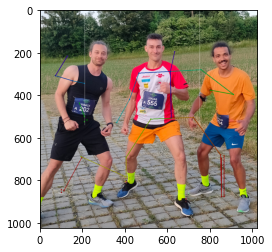

In [2]:
%matplotlib inline

frame = cv2.imread('data/multi.jpg')
frame = cv2.resize(frame, (1024,1024))


res = dpu_ICAIPose.process(frame)

res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)

plt.imshow(res)


In [1]:
ims = np.load('data/ims.npy')
out = []

for im in ims[:10]:
    res = dpu_ICAIPose.process(im)


NameError: name 'np' is not defined

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
cm = np.load('conf_map_fpga.npy')
cm = (cm+np.random.randint(5,9,size=(256,256), dtype=np.uint8)).astype(np.uint8)
np.min(cm.dtype)
# cm = np.clip(cm, 0, 255).astype(np.uint16)*1000+np.random.randint(0,255,size=(256,256), dtype=np.uint16)
# dil = cv2.dilate(cm, np.ones((5,5),dtype=np.uint16), 1)
# cor = np.nonzero(np.logical_and(cm == dil, cm>20*1000))

# plt.imshow(cm)
# plt.show()

# plt.imshow(dil)
# plt.show()

dtype('uint8')

In [14]:
import numpy as np

cm = np.random.randint(-4,5,size=(5,5), dtype=np.int8)
np.abs(cm*255).astype(np.uint16)


array([[ 510,  765, 1020,  510,  765],
       [ 510, 1020, 1020,  255,  255],
       [1020,  510,  255,  255,  510],
       [ 510, 1020,  510,  765,  510],
       [1020,  510,  765,  510,  765]], dtype=uint16)